In [1]:
!pip install -q rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.1 MB/s eta 0:00:00:00:0100:01


## Imports

In [2]:
import rasterio
import os
import numpy as np
from tqdm import tqdm
from datetime import datetime
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict

## Parameters

In [3]:
# Paths and settings
BASE_PATH           = '/kaggle/input/sentinel2-crop-mapping'
REGIONS             = ['lombardia', 'lombardia2']
YEARS               = ['data2016', 'data2017', 'data2018']
CLASS_FILE          = f'{BASE_PATH}/lombardia-classes/classes25pc.txt'
NUM_TIMESTEPS       = 32
NUM_CLASSES         = 7
BATCH_SIZE          = 16
NUM_WORKERS         = 4
LR                  = 1e-4
NUM_EPOCHS          = 15
DEVICE              = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VALID_LABELS = ['Cereals', 'Maize', 'Rice', 'Forage', 'Unknown Crop', 'Woods/Tree Crops', 'Non-agricultural']
label_remap = {
    2: 0,  # Cereals
    9: 1,  # Maize
    12: 2, # Rice
    7: 3,  # Forage
    1: 4, 3: 4, 5: 4, 6: 4, 8: 4, 10: 4, 11: 4, 13: 4, 14: 4, 15: 4, 16: 4, 19: 4, 255:4,  # Unknown crop
    4: 5,  # Woods/tree crops
    17: 6, 18: 6, 20: 6, 21: 6,  # Non-agricultural
}

## Dataset Preprocessing and Loading

In [4]:
def yyyymmdd_to_mmdd(yyyymmdd):
    """Extract MMDD as int from YYYYMMDD string."""
    return int(str(yyyymmdd)[4:])


def load_crop_intervals(class_file_path):
    """
    Parses crop intervals ignoring year — stores start and end MMDD as ints.
    Each line is: class_id(s)|class_name|start_date|end_date
    """
    crop_intervals = {}

    with open(class_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            if len(parts) != 4:
                continue
            class_ids = [int(cid) for cid in parts[0].split(',')]
            start_mmdd = yyyymmdd_to_mmdd(parts[2])
            end_mmdd   = yyyymmdd_to_mmdd(parts[3])
            for cid in class_ids:
                crop_intervals[cid] = (start_mmdd, end_mmdd)

    return crop_intervals


def remap_labels(mask, remap_dict, ignore_index=255):
    """Remap labels in a mask tensor according to remap_dict."""
    output = torch.full_like(mask, fill_value=ignore_index)
    for old_label, new_label in remap_dict.items():
        output[mask == old_label] = new_label
    return output


class TimeAwareSentinel2Dataset(torch.utils.data.Dataset):
    def __init__(self, root, regions, years, class_file, num_timesteps=32):
        self.crop_intervals = load_crop_intervals(class_file)
        self.num_timesteps = num_timesteps
        self.tiles = []

        print("Indexing tile timesteps...")
        for region in regions:
            for year in years:
                year_path = os.path.join(root, region, year)
                tile_dirs = sorted(os.listdir(year_path))

                for tile_name in tqdm(tile_dirs[:2500:10], desc=f"    {region}/{year}"):
                    tile_path = os.path.join(year_path, tile_name)

                    tif_files = sorted([
                        f for f in os.listdir(tile_path)
                        if f.endswith('.tif') and '_MSAVI' not in f and f != 'y.tif'
                    ])

                    if len(tif_files) < num_timesteps:
                        continue

                    selected_files = tif_files[:num_timesteps]
                    image_paths = [os.path.join(tile_path, f) for f in selected_files]
                    date_strs   = [f.replace('.tif', '') for f in selected_files]
                    mask_path   = os.path.join(tile_path, 'y.tif')

                    self.tiles.append((image_paths, mask_path, date_strs))

        print(f"Total tiles: {len(self.tiles)}")

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        image_paths, mask_path, date_strs = self.tiles[idx]
        time_images = []
        time_masks = []

        with rasterio.open(mask_path) as src:
            raw_mask = src.read(1)  # original labels (0–21, 255)

        remapped_mask = remap_labels(torch.from_numpy(raw_mask), label_remap, ignore_index=255).numpy()
        
        for img_path, date_str in zip(image_paths, date_strs):
            with rasterio.open(img_path) as src:
                image = src.read()  # (C, H, W)

            image_tensor = torch.from_numpy(image).float()
            img_mmdd = yyyymmdd_to_mmdd(date_str)
            
            masked = np.full_like(raw_mask, fill_value=255, dtype=np.uint8)

            for old_cid, (start_mmdd, end_mmdd) in self.crop_intervals.items():
                if old_cid == 255:
                    continue  # skip unknown/ignore class
                    
                if start_mmdd <= end_mmdd:
                    valid = start_mmdd <= img_mmdd <= end_mmdd
                else:
                    # Interval wraps around (e.g., Sep to Mar)
                    valid = img_mmdd >= start_mmdd or img_mmdd <= end_mmdd

                if valid:
                    new_cid = label_remap.get(old_cid, 255)
                    masked[raw_mask == old_cid] = new_cid

            mask_tensor = torch.from_numpy(masked).long()
            time_images.append(image_tensor)
            time_masks.append(mask_tensor)

        time_images = torch.stack(time_images)  # (T, C, H, W)
        time_masks = torch.stack(time_masks)    # (T, H, W)

        return time_images, time_masks

In [5]:
# Build dataset 
ds = TimeAwareSentinel2Dataset(
    root=BASE_PATH,
    regions=REGIONS,
    years=YEARS,
    class_file=CLASS_FILE,
    num_timesteps=NUM_TIMESTEPS
)

# Split by tile index
total_tiles = len(ds) // NUM_TIMESTEPS
tile_indices = list(range(total_tiles))
train_tiles, val_tiles = train_test_split(tile_indices, test_size=0.2, random_state=42)

def get_subset(dataset, tile_indices, timesteps_per_tile=NUM_TIMESTEPS):
    indices = []
    for tile_idx in tile_indices:
        base = tile_idx * timesteps_per_tile
        indices.extend(list(range(base, base + timesteps_per_tile)))
    return torch.utils.data.Subset(dataset, indices)

train_ds = get_subset(ds, train_tiles)
val_ds   = get_subset(ds, val_tiles)

print('Train Dataset', len(train_ds))
print('Val Dataset: ', len(val_ds))

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

Indexing tile timesteps...


    lombardia2/data2018: 100%|██████████| 250/250 [00:02<00:00, 90.32it/s]

Total tiles: 1500
Train Dataset 1152
Val Dataset:  320


Unique class values per mask:
20160110: [0, 255]
20160120: [0, 255]
20160130: [0, 3, 255]
20160209: [0, 3, 4, 6, 255]
20160219: [0, 3, 4, 6, 255]
20160310: [0, 3, 4, 6, 255]
20160320: [0, 3, 4, 6, 255]
20160330: [0, 3, 4, 6, 255]
20160409: [0, 3, 4, 6, 255]
20160419: [0, 3, 4, 6, 255]
20160429: [0, 1, 3, 4, 6]
20160509: [0, 1, 3, 4, 6]
20160519: [0, 1, 3, 4, 6]
20160529: [0, 1, 3, 4, 6]
20160608: [0, 1, 3, 4, 6]
20160618: [0, 1, 3, 4, 6]
20160628: [0, 1, 3, 4, 6]
20160708: [1, 3, 4, 6, 255]
20160718: [1, 4, 6, 255]
20160728: [1, 4, 6, 255]
20160807: [1, 4, 6, 255]
20160817: [1, 4, 6, 255]
20160827: [1, 4, 6, 255]
20160906: [1, 4, 6, 255]
20160916: [4, 6, 255]
20160926: [4, 6, 255]
20161006: [4, 6, 255]
20161016: [4, 6, 255]
20161105: [4, 6, 255]
20161115: [0, 4, 6, 255]
20161125: [0, 4, 6, 255]
20161205: [0, 4, 6, 255]


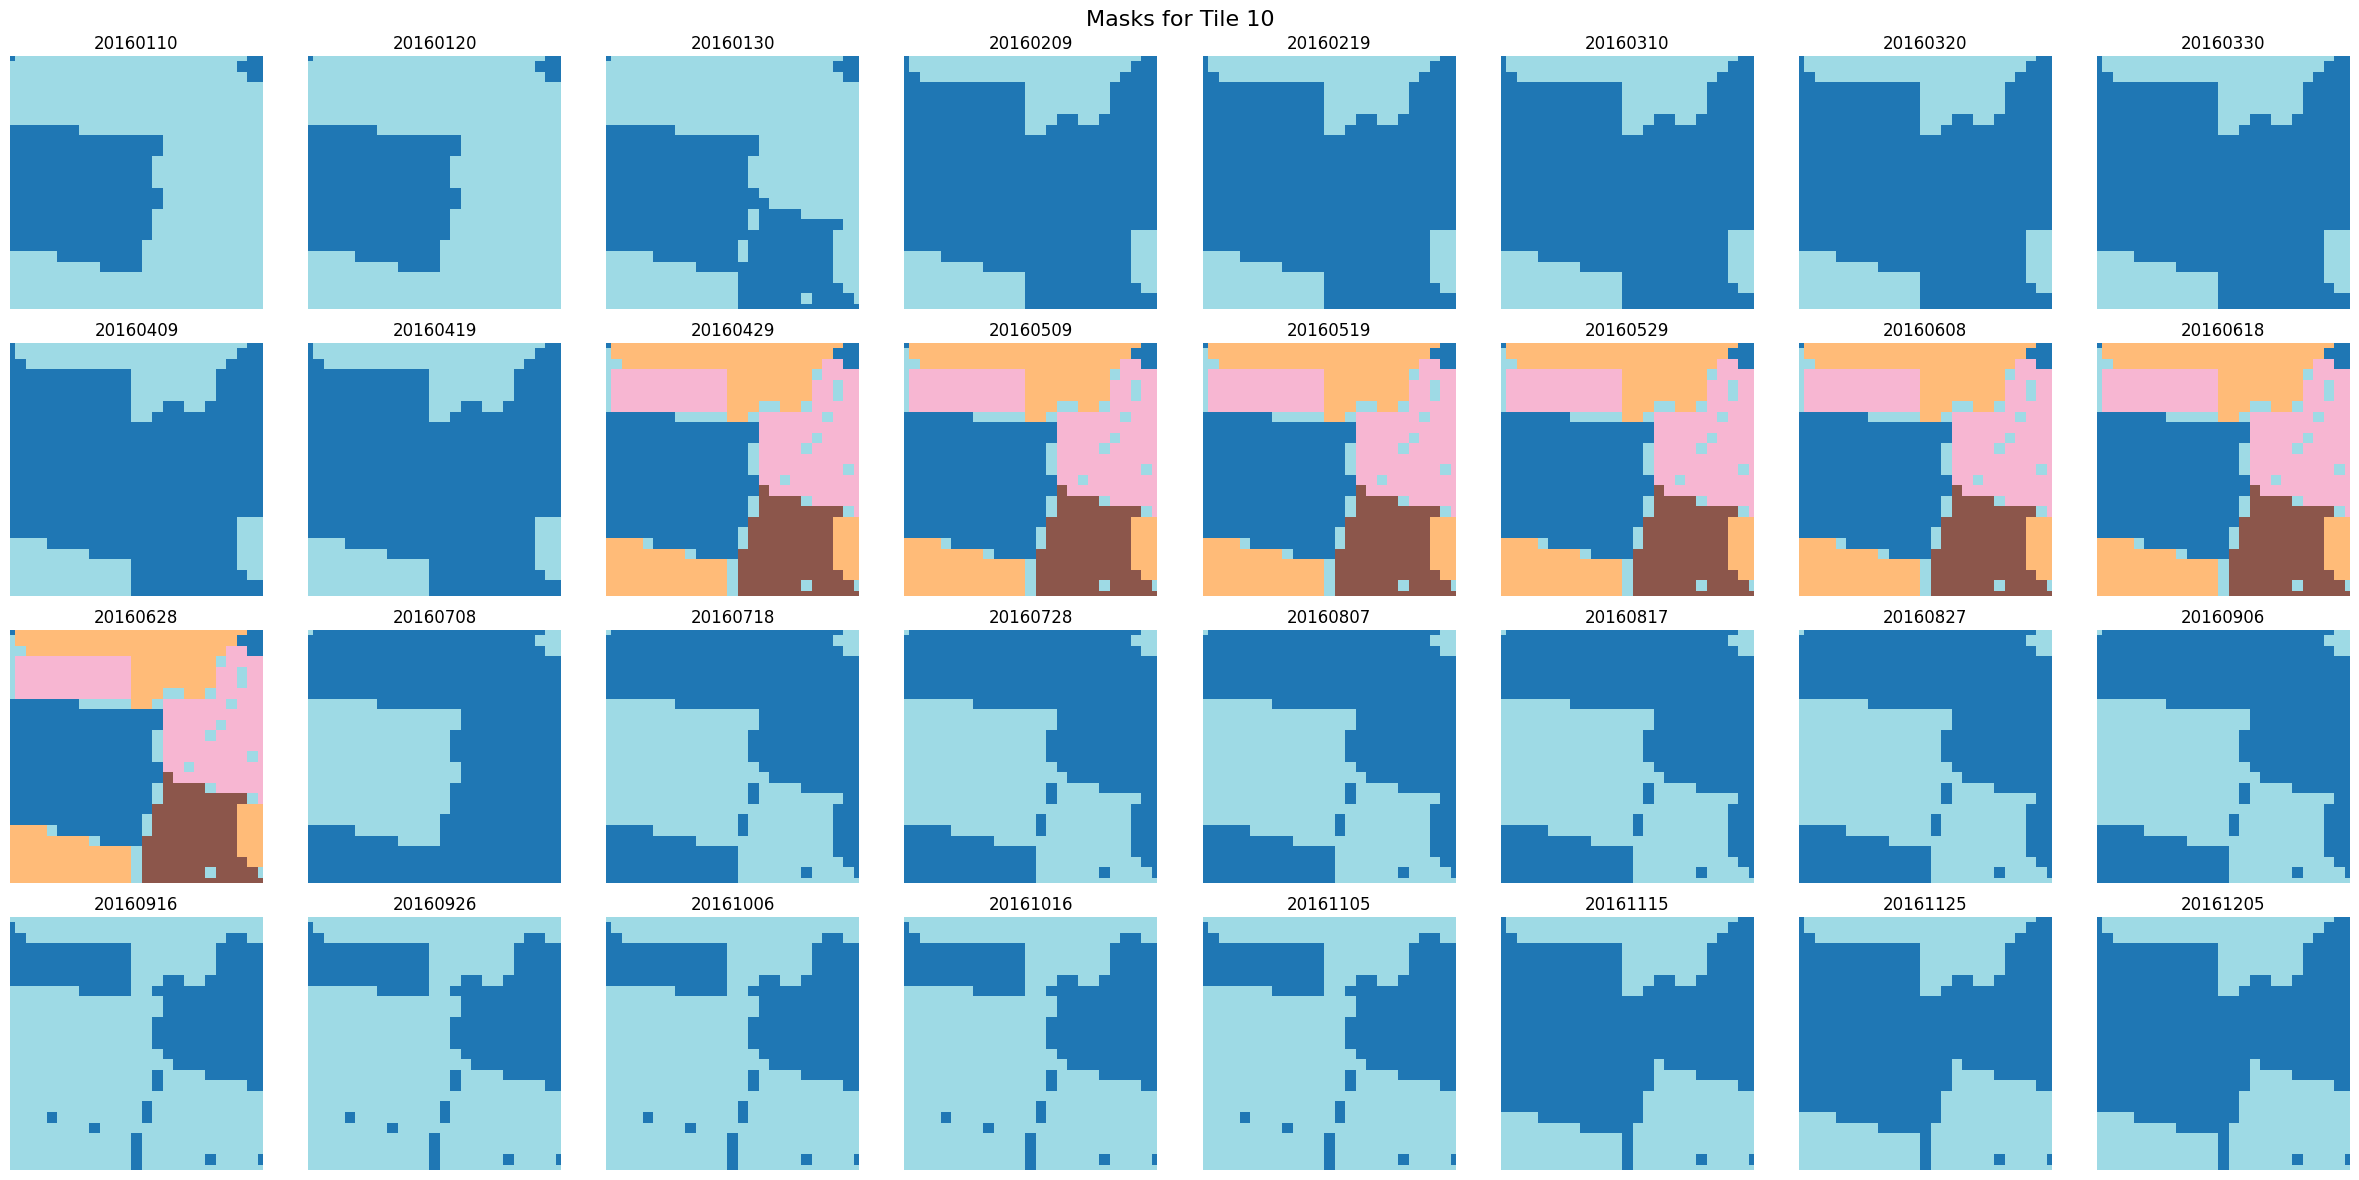

In [6]:
# Pick any tile index (0 to len(ds) - 1)
tile_idx = 10

images, masks = ds[tile_idx]
_, _, date_strs = ds.tiles[tile_idx]

print("Unique class values per mask:")
for t, mask in enumerate(masks):
    unique_vals = torch.unique(mask)
    print(f"{date_strs[t]}: {unique_vals.tolist()}")

# Load the tile's time series (images and masks)
images, masks = ds[tile_idx]

# Get the corresponding date strings
_, _, date_strs = ds.tiles[tile_idx]  # Get the raw dates for inspection

# Plot masks over time
ncols = 8
nrows = int(np.ceil(len(masks) / ncols))

plt.figure(figsize=(3*ncols, 3*nrows))
for t in range(len(masks)):
    plt.subplot(nrows, ncols, t+1)
    plt.imshow(masks[t].numpy(), cmap='tab20')
    plt.title(f"{date_strs[t]}")
    plt.axis('off')
plt.suptitle(f"Masks for Tile {tile_idx}", fontsize=16)
plt.tight_layout()
plt.show()

<hr>

## 3D CNN Model

-> Since the 2D CNN model can't handle the additional temporal dimension, 3D CNN is used.

In [23]:
class UNet3DBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.enc1 = UNet3DBlock(in_channels, 64)
        self.enc2 = UNet3DBlock(64, 128)

        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.bottleneck = UNet3DBlock(128, 256)

        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec2 = UNet3DBlock(256, 128)

        self.up1 = nn.ConvTranspose3d(128, 64, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec1 = UNet3DBlock(128, 64)

        self.final = nn.Conv3d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Input: (B, C, T, H, W)
        e1 = self.enc1(x)            # 64 x T x H x W
        e2 = self.enc2(self.pool(e1))  # 128 x T/2 x H/2 x W/2
        
        b  = self.bottleneck(self.pool(e2))
        
        d2 = self.up2(b)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = self.final(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='trilinear', align_corners=False)
        return out


in_channels = 9  # since each timestep has 9 bands
model = UNet3D(in_channels, NUM_CLASSES).to(DEVICE)
print(model)

UNet3D(
  (enc1): UNet3DBlock(
    (block): Sequential(
      (0): Conv3d(9, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): UNet3DBlock(
    (block): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool): MaxPool3d(kernel_size=(1, 2, 2), s

<hr>

## Defining Loss

In [8]:
def focal_loss_3d(logits, targets, alpha=None, gamma=2.0, ignore_index=255):
    """
    logits: (B, C, T, H, W)
    targets: (B, T, H, W)
    """
    B, C, T, H, W = logits.shape

    # Flatten for loss computation: (B*T*H*W,)
    logits_flat = logits.permute(0, 2, 3, 4, 1).reshape(-1, C)     # → (B*T*H*W, C)
    targets_flat = targets.reshape(-1)                            # → (B*T*H*W,)

    # Cross Entropy per-pixel
    ce_loss = torch.nn.functional.cross_entropy(
        logits_flat, targets_flat,
        reduction='none',
        weight=alpha,
        ignore_index=ignore_index
    )

    pt = torch.exp(-ce_loss)      # prob assigned to true class
    focal_term = (1 - pt) ** gamma
    loss = focal_term * ce_loss

    # Apply mask for ignore_index
    if ignore_index is not None:
        mask = targets_flat != ignore_index
        loss = loss[mask]

    return loss.mean()

In [9]:
def compute_class_weights(dataset, num_classes=NUM_CLASSES, ignore_index=255):
    """
    Computes class weights as inverse frequency from the full dataset.
    """
    class_counts = torch.zeros(num_classes)
    total_pixels = 0

    print("Computing class weights...")
    for i in tqdm(range(len(dataset))):
        _, masks = dataset[i]  # masks: (T, H, W)

        for t in range(masks.shape[0]):
            mask = masks[t].flatten()
            valid = mask != ignore_index
            pixels = mask[valid]

            total_pixels += len(pixels)
            for cls in range(num_classes):
                class_counts[cls] += (pixels == cls).sum()

    # Avoid divide-by-zero
    smooth = 1.0 
    class_weights = total_pixels / (num_classes * (class_counts + smooth))
    class_weights = class_weights / class_weights.sum()  # Normalize

    return class_weights.float()

class_weights = compute_class_weights(ds, num_classes=NUM_CLASSES)
class_weights = class_weights.to(DEVICE)  # ← Move to GPU only when needed
print(class_weights)

Computing class weights...


100%|██████████| 1500/1500 [08:38<00:00,  2.89it/s]


tensor([0.1935, 0.1126, 0.1224, 0.2071, 0.0893, 0.1926, 0.0825],
       device='cuda:0')


In [10]:
loss_type = 'ce'  

if loss_type == 'ce':
    criterion = nn.CrossEntropyLoss(
        ignore_index=255,
        weight=class_weights
    )
    def compute_loss(logits, targets):
        B, C, T, H, W = logits.shape
        logits_flat = logits.permute(0, 2, 3, 4, 1).reshape(-1, C)
        targets_flat = targets.reshape(-1)
        return criterion(logits_flat, targets_flat)

elif loss_type == 'focal':
    def compute_loss(logits, targets):
        return focal_loss_3d(
            logits, targets,
            alpha=class_weights,
            gamma=2.0,
            ignore_index=255
        )

else:
    raise ValueError(f"Unsupported loss_type: {loss_type}")


# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [11]:
@torch.no_grad()
def pixel_accuracy(logits, targets, ignore_index=255):
    """
    logits: (B, C, T, H, W)
    targets: (B, T, H, W)
    """
    preds = logits.argmax(dim=1)  # → (B, T, H, W)
    valid = targets != ignore_index
    correct = (preds == targets) & valid
    total = valid.sum()
    if total == 0:
        return 0.0
    return correct.sum().float().item() / total.item()

<hr>

## Training Loop

In [24]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    t_loss, t_acc = 0.0, 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        # x: (B, T, C, H, W), y: (B, T, H, W)
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Permute x to (B, C, T, H, W) for Conv3D
        x = x.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        out = model(x)  # Output: (B, NUM_CLASSES, T, H, W)

        loss = compute_loss(out, y)
        loss.backward()
        optimizer.step()

        t_loss += loss.item()
        t_acc += pixel_accuracy(out, y)  # averaged over T

    t_loss /= len(train_loader)
    t_acc /= len(train_loader)
    train_losses.append(t_loss)
    train_accuracies.append(t_acc)

    # ----- Validation -----
    model.eval()
    v_loss, v_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch} Validating"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            x = x.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W) → (B, C, T, H, W)
            out = model(x)  # (B, NUM_CLASSES, T, H, W)

            loss = compute_loss(out, y)
            v_loss += loss.item()
            v_acc += pixel_accuracy(out, y)

    v_loss /= len(val_loader)
    v_acc /= len(val_loader)
    val_losses.append(v_loss)
    val_accuracies.append(v_acc)

    scheduler.step(v_loss)

    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {t_loss:.4f}, Acc: {t_acc:.4f} | "
          f"Val Loss: {v_loss:.4f}, Acc: {v_acc:.4f}")

Epoch 1 Validating: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epoch 1/15 | Train Loss: 2.0422, Acc: 0.1111 | Val Loss: 2.0385, Acc: 0.1121


Epoch 2 Validating: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch 2/15 | Train Loss: 2.0419, Acc: 0.1111 | Val Loss: 2.0395, Acc: 0.1117


Epoch 3 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch 3/15 | Train Loss: 2.0414, Acc: 0.1111 | Val Loss: 2.0415, Acc: 0.1120


Epoch 4 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch 4/15 | Train Loss: 2.0431, Acc: 0.1111 | Val Loss: 2.0397, Acc: 0.1118


Epoch 5 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch 5/15 | Train Loss: 2.0412, Acc: 0.1113 | Val Loss: 2.0395, Acc: 0.1122


Epoch 6 Validating: 100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


Epoch 6/15 | Train Loss: 2.0422, Acc: 0.1112 | Val Loss: 2.0424, Acc: 0.1122


Epoch 7 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch 7/15 | Train Loss: 2.0424, Acc: 0.1111 | Val Loss: 2.0398, Acc: 0.1123


Epoch 8 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch 8/15 | Train Loss: 2.0423, Acc: 0.1108 | Val Loss: 2.0408, Acc: 0.1119


Epoch 9 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Epoch 9/15 | Train Loss: 2.0426, Acc: 0.1109 | Val Loss: 2.0405, Acc: 0.1123


Epoch 10 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch 10/15 | Train Loss: 2.0422, Acc: 0.1112 | Val Loss: 2.0414, Acc: 0.1121


Epoch 11 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Epoch 11/15 | Train Loss: 2.0422, Acc: 0.1109 | Val Loss: 2.0418, Acc: 0.1126


Epoch 12 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Epoch 12/15 | Train Loss: 2.0418, Acc: 0.1110 | Val Loss: 2.0413, Acc: 0.1121


Epoch 13 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Epoch 13/15 | Train Loss: 2.0423, Acc: 0.1112 | Val Loss: 2.0406, Acc: 0.1124


Epoch 14 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Epoch 14/15 | Train Loss: 2.0419, Acc: 0.1113 | Val Loss: 2.0401, Acc: 0.1121


Epoch 15 Validating: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

Epoch 15/15 | Train Loss: 2.0427, Acc: 0.1110 | Val Loss: 2.0419, Acc: 0.1122


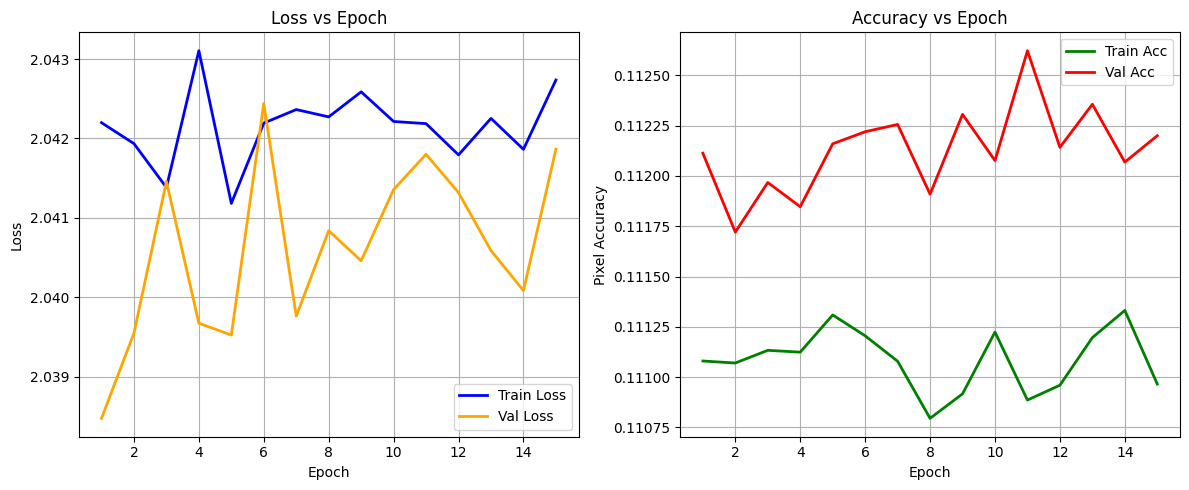

In [25]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# ---- LOSS ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(epochs, val_losses,   label='Val Loss',   color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

# ---- ACCURACY ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc', color='green', linewidth=2)
plt.plot(epochs, val_accuracies,   label='Val Acc',   color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

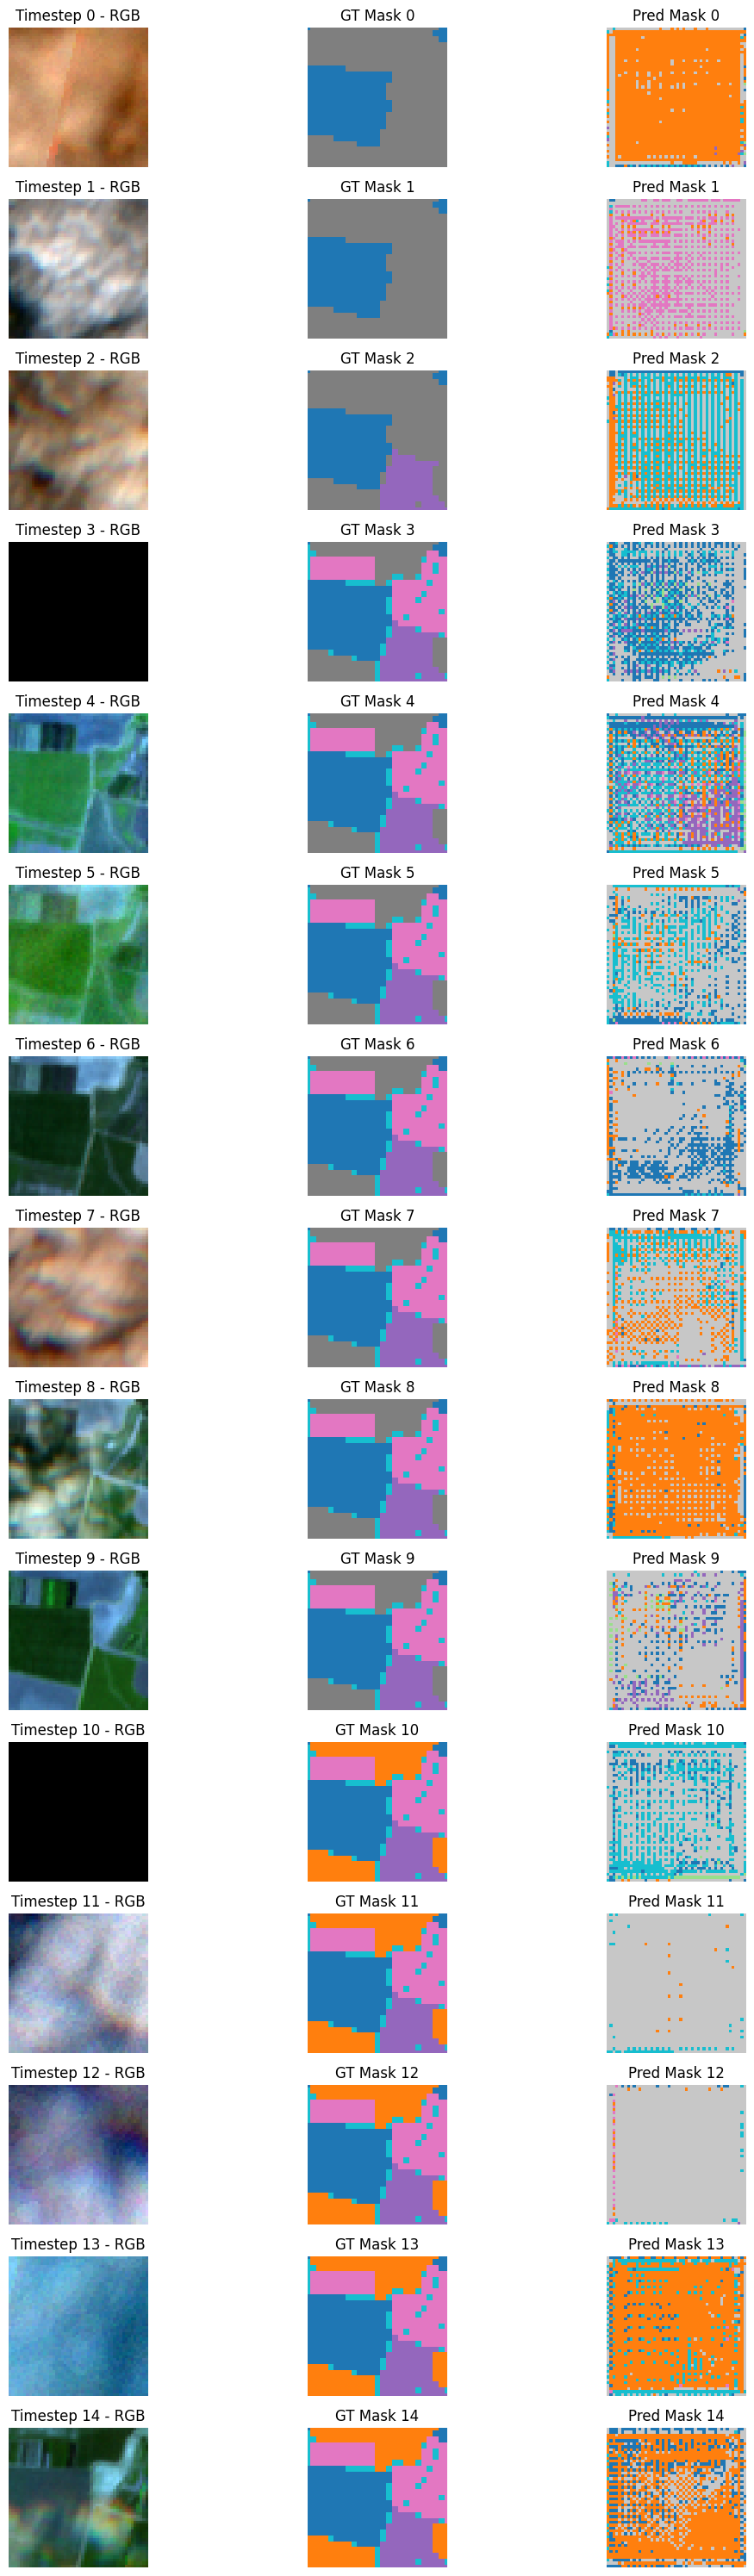

In [26]:
def visualize_predictions(model, dataset, tile_index, class_names=None, num_timesteps=15, ignore_index=255):
    model.eval()
    img, gt_mask = dataset[tile_index]  # (T, C, H, W), (T, H, W)
    T, C, H, W = img.shape
    num_timesteps = min(num_timesteps, T)

    img_input = img.permute(1, 0, 2, 3).unsqueeze(0).to(DEVICE)  # (1, C, T, H, W)
    with torch.no_grad():
        logits = model(img_input)  # (1, NUM_CLASSES, T, H, W)
        preds = logits.argmax(dim=1).squeeze(0).cpu()  # (T, H, W)

    # Custom colormap: tab20 but with ignore_index as gray
    cmap = plt.get_cmap('tab20', 22)
    colors = cmap.colors
    colors = np.vstack([colors, [0.5, 0.5, 0.5, 1.0]])  # RGBA gray
    new_cmap = ListedColormap(colors)

    fig, axes = plt.subplots(num_timesteps, 3, figsize=(12, num_timesteps * 2))

    for t in range(num_timesteps):
        rgb = img[t, :3].permute(1, 2, 0).cpu().numpy()
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

        gt = gt_mask[t].cpu().numpy()
        pred = preds[t].cpu().numpy()

        # Replace ignore_index with NUM_CLASSES (last colormap entry → gray)
        gt_vis = np.where(gt == ignore_index, NUM_CLASSES, gt)
        pred_vis = np.where(pred == ignore_index, NUM_CLASSES, pred)

        axes[t, 0].imshow(rgb)
        axes[t, 0].set_title(f"Timestep {t} - RGB")

        axes[t, 1].imshow(gt_vis, cmap=new_cmap, vmin=0, vmax=NUM_CLASSES)
        axes[t, 1].set_title(f"GT Mask {t}")

        axes[t, 2].imshow(pred_vis, cmap=new_cmap, vmin=0, vmax=NUM_CLASSES)
        axes[t, 2].set_title(f"Pred Mask {t}")

        for ax in axes[t]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, ds, tile_index=10)

Confusion Matrix Eval: 100%|██████████| 320/320 [00:43<00:00,  7.29it/s]


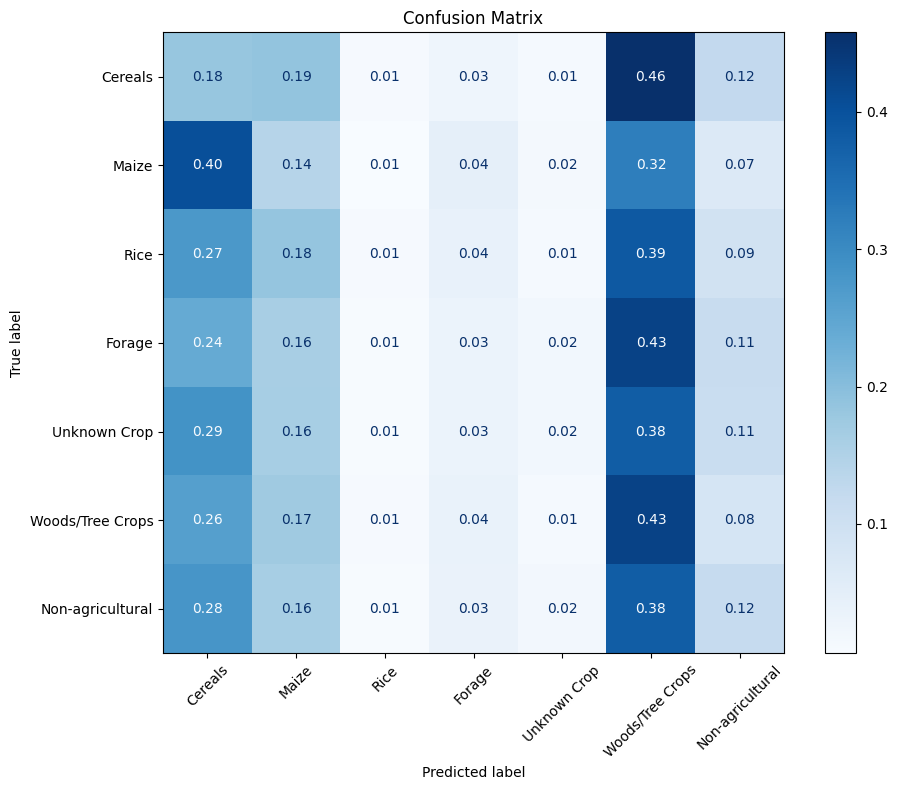

In [27]:
def compute_confusion_matrix(model, dataset, num_classes=NUM_CLASSES, ignore_index=255):
    """
    Computes the confusion matrix over the entire dataset.
    """
    model.eval()
    all_preds = []
    all_targets = []

    for i in tqdm(range(len(dataset)), desc="Confusion Matrix Eval"):
        img, gt_mask = dataset[i]  # img: (T, C, H, W), gt_mask: (T, H, W)
        T, C, H, W = img.shape

        # Prepare input
        img_input = img.permute(1, 0, 2, 3).unsqueeze(0).to(DEVICE)  # (1, C, T, H, W)
        with torch.no_grad():
            logits = model(img_input)  # (1, num_classes, T, H, W)
            pred_mask = logits.argmax(dim=1).squeeze(0)  # (T, H, W)

        # Flatten and mask
        pred_flat = pred_mask.cpu().numpy().reshape(-1)
        gt_flat = gt_mask.numpy().reshape(-1)

        valid = gt_flat != ignore_index
        all_preds.append(pred_flat[valid])
        all_targets.append(gt_flat[valid])

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    cm = confusion_matrix(all_targets, all_preds, labels=np.arange(num_classes))
    return cm

def plot_confusion_matrix(cm, class_names=None, normalize=False):
    """
    Plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype(float)
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # avoid division by zero
        cm = cm / row_sums


    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(VALID_LABELS))
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, colorbar=True, values_format='.2f')    
    ax.set_title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

cm = compute_confusion_matrix(model, val_ds, num_classes=NUM_CLASSES)
plot_confusion_matrix(cm, class_names=VALID_LABELS, normalize=True)

<hr>